## Libraries and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, TimeDistributed, Attention, Add, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import os
import json
import joblib
import matplotlib.pyplot as plt

In [3]:
def load_dataset(filepath):
    return pd.read_csv(filepath)

def save_dataset(dataset, filepath):
    dataset.to_csv(filepath, index=False)

def dataset_split(X, y, split_size, shuffle=True):
    return train_test_split(X, y, test_size=split_size, shuffle=shuffle, random_state=42)

def sklearn_model_load(directory):
    model = joblib.load(f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'r') as config_file:
        config = json.load(config_file)

    return model, config

def sklearn_model_save(directory, model, config):
    if not os.path.exists(directory):
        os.makedirs(directory)

    joblib.dump(model, f'{directory}/model.joblib')

    with open(f'{directory}/config.json', 'w') as config_file:
        json.dump(config, config_file)

collective_metrics = {}

## Load and prepare dataset

In [4]:
scaler = joblib.load('/content/drive/My Drive/Machine Learning/Final Project/scaler.joblib')
encoder = joblib.load('/content/drive/My Drive/Machine Learning/Final Project/encoder.joblib')

In [5]:
dataset = load_dataset('/content/drive/My Drive/Machine Learning/Final Project/energydata_preprocessed.csv')

X = dataset.drop(columns=['date', 'Appliances'])
y = dataset['Appliances']

## LSTM Model

### Train model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)

lags = 66

n_features = X_train.shape[1]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

generator_train = TimeseriesGenerator(X_train, y_train, length=lags, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=lags, batch_size=32)


model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(lags, n_features)),
    LeakyReLU(negative_slope=0.3),
    Dropout(0.09),
    Dense(128, activation='relu'),

    LSTM(256, return_sequences=True),
    LeakyReLU(negative_slope=0.15),
    Dropout(0.08),

    LSTM(128, return_sequences=True),
    LeakyReLU(negative_slope=0.07),
    Dropout(0.07),

    LSTM(128, return_sequences=True),
    LeakyReLU(negative_slope=0.07),
    Dropout(0.06),
    Dense(128, activation='relu'),

    LSTM(64, return_sequences=True),
    LeakyReLU(negative_slope=0.04),
    Dropout(0.05),

    LSTM(64, return_sequences=False),
    LeakyReLU(negative_slope=0.04),
    Dropout(0.04),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])

history = model.fit(generator_train,
                    validation_data=generator_val,
                    epochs=100,
                    batch_size=64,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


418/418 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0150 - mae: 0.0698 - val_loss: 0.0082 - val_mae: 0.0509
Epoch 2/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0088 - mae: 0.0552 - val_loss: 0.0082 - val_mae: 0.0553
Epoch 3/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0092 - mae: 0.0594 - val_loss: 0.0082 - val_mae: 0.0554
Epoch 4/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0108 - mae: 0.0639 - val_loss: 0.0083 - val_mae: 0.0447
Epoch 5/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0108 - mae: 0.0607 - val_loss: 0.0080 - val_mae: 0.0564
Epoch 6/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0092 - mae: 0.0571 - val_loss: 0.0078 - val_mae: 0.0488
Epoch 7/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0084 - mae: 0.0542 - val_loss: 0.0078 - val_mae: 0.0504
Epoch 8/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0082 - mae: 0.0519 - val_loss: 0.0077 - val_mae: 0.0446
Epoch 9/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 20s

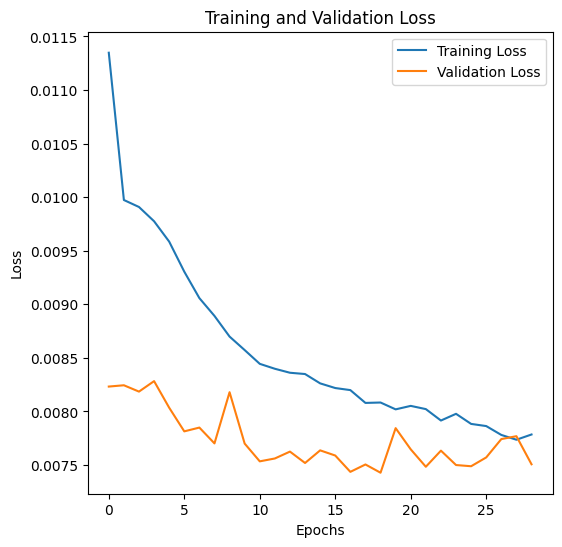

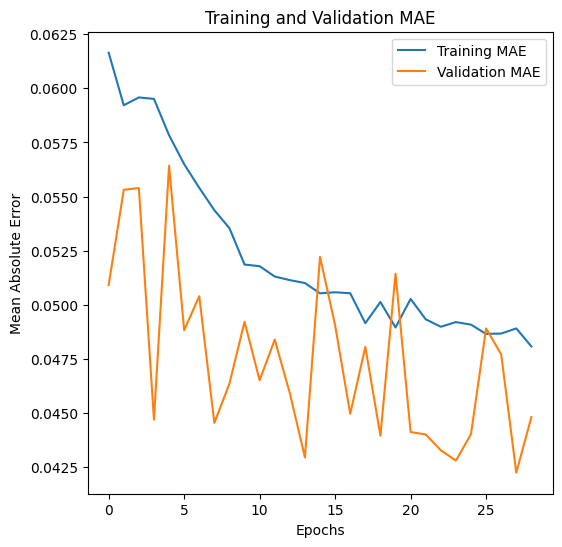

In [7]:
# Plot training and validation loss
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(6, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()


### Load model if already trained

### Test model

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mae: 0.0392
Mean Absolute Error (MAE): 47.123
Mean Squared Error (MSE): 7111.105
Root Mean Squared Error (RMSE): 84.327
R² Score: 0.050


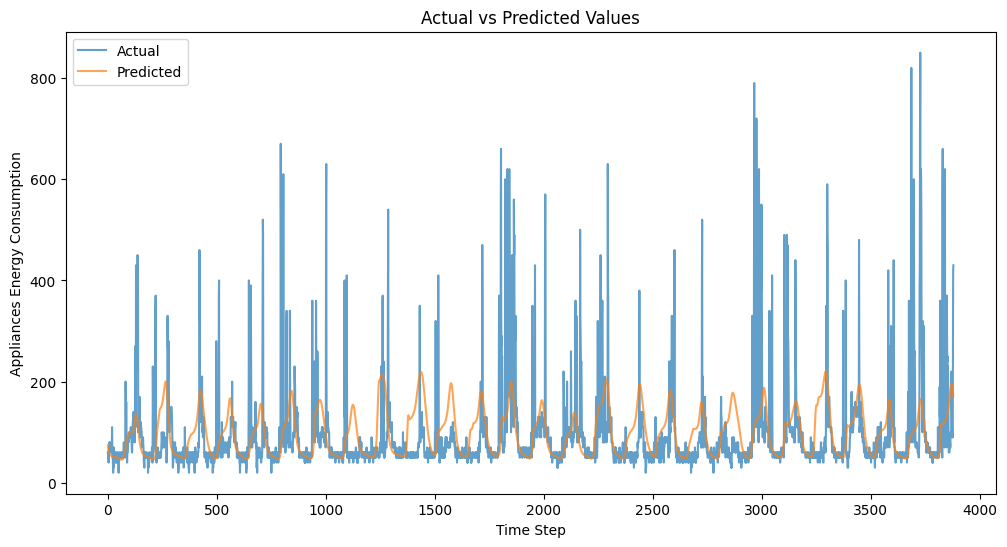

In [9]:
X_test = np.array(X_test)
y_test = np.array(y_test)

generator_test = TimeseriesGenerator(X_test, y_test, length=lags, batch_size=32)

y_pred = model.predict(generator_test)

numerical_columns = [
    'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3',
    'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8',
    'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
    'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM'
]

y_test_actual = y_test[lags:]
y_pred = np.squeeze(y_pred)

dummy_array = np.zeros((len(y_pred), len(numerical_columns)))

target_index = numerical_columns.index('Appliances')

dummy_array[:, target_index] = y_pred
y_pred_original = scaler.inverse_transform(dummy_array)[:, target_index]

dummy_array[:, target_index] = y_test_actual
y_test_original = scaler.inverse_transform(dummy_array)[:, target_index]

mae_original = mean_absolute_error(y_test_original, y_pred_original)
mse_original = mean_squared_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)

collective_metrics['lstm'] = {
    'mae': mae_original,
    'mse': mse_original,
    'loss': model.evaluate(generator_test)
}

print(f"Mean Absolute Error (MAE): {mae_original:.3f}")
print(f"Mean Squared Error (MSE): {mse_original:.3f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_original):.3f}")
print(f"R² Score: {r2_original:.3f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', alpha=0.7)
plt.plot(y_pred_original, label='Predicted', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Appliances Energy Consumption')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

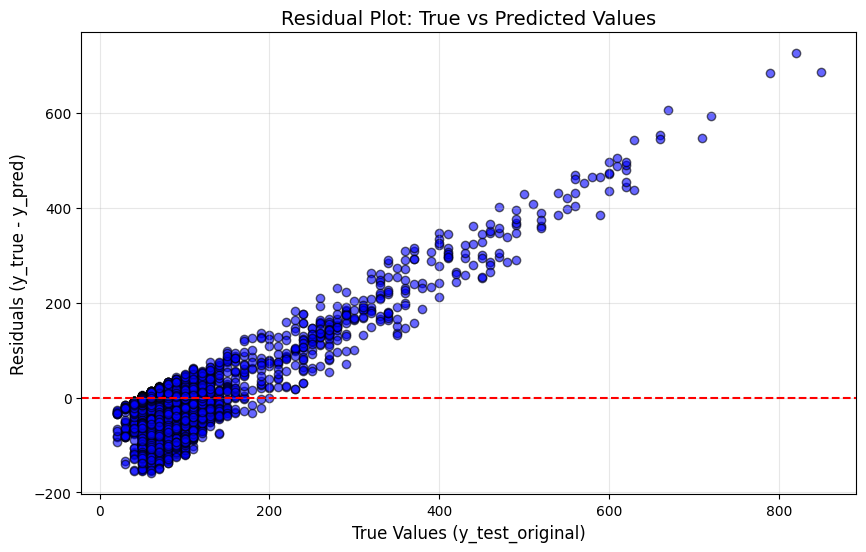

In [10]:
residuals = y_test_original - y_pred_original

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, residuals, alpha=0.6, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residual Plot: True vs Predicted Values', fontsize=14)
plt.xlabel('True Values (y_test_original)', fontsize=12)
plt.ylabel('Residuals (y_true - y_pred)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


### Save model

In [ ]:
sklearn_model_save('/content/drive/My Drive/Machine Learning/Final Project/Models/gbm', model, {})